# Conformal prediction for regression

In [1]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.base import clone

from mapie.regression import MapieRegressor

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps

In [2]:
random_state = 42
np.random.seed(random_state)
epsilon = 0.05
mu, sigma, n_samples, noise = 0, 5, 500, 1

In [3]:
def are_both_intervals_equal(interval1,interval2):
    print("Are both inervals equal?")
    if np.all(interval1 == interval2):
        print("Yes, both are equal!")
    else:
        print("No, both are not equal!")

def calculate_quantile(scores, epsilon, method="higher", axis=0):
    if len(scores.shape) == 1:
        n, = scores.shape
    else:
        _,n = scores.shape
    return np.quantile(
        scores,
        axis=axis,
        q=((n + 1) * (1 - epsilon)) / n,
        method=method,
    )

def target_function(X):
    return X * np.sin(X) * np.cos(X)

def create_regression_data(mu,sigma, n_samples, noise):
    X_train = np.random.normal(mu,sigma,n_samples).reshape(-1,1)
    X_test = np.arange(mu - 2.5*sigma, mu + 2.5*sigma, sigma/10).reshape(-1,1)
    
    y_train = target_function(X_train) + np.random.normal(0,
                                                          noise,
                                                          X_train.shape[0])[:,None]
    y_test = target_function(X_test) + np.random.normal(0,
                                                        noise,
                                                        X_test.shape[0])[:,None]

    return (
        X_train,
        X_test,
        y_train.ravel(),
        y_test.ravel()
    )

X_train,X_test,y_train,y_test = create_regression_data(mu,
                                                       sigma,
                                                       n_samples,
                                                       noise)

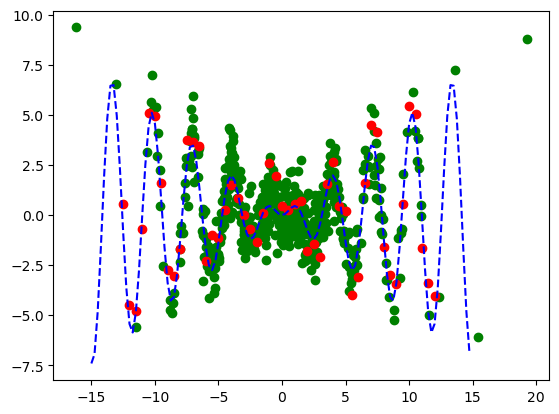

In [4]:
X_general = np.arange(mu - 3*sigma, mu + 3*sigma, step = sigma/20)
norm_quantile = sps.norm.ppf(1 - epsilon) 


fig,ax = plt.subplots()

ax.plot(X_general,target_function(X_general), color="blue",ls="--",label="ground_truth")
ax.scatter(X_train,y_train,color="green",label="train_data")
ax.scatter(X_test,y_test,color="red",label="testing data")
plt.show()

We now discuss Conformal prediction applied to regression tasks. We recommend reading the Chapter on Conformal Classification (Section ....) as it covers the general idea. Regression is done through inductive conformal prediction which can be briefly described as follows:
1. Split the data into a training set and calibration set.
2. Train a arbitrary machine learning model on the training set
3. Calculate the non-conformity scores for the calibration set
4. Use these value to create a prediction interval for each new observation.

The non-conformity function $f$ can be seen as the ''weirdness' of a label $y$ given the features $x$.
In the following we will introduce the *Split*-Method for constructing the non-conformity scores.
We split the data into $l$ training, $k$ validation and $N-k-l$ testing data points.
## Split-Method

In [5]:
X_train_prefit,X_val_prefit,y_train_prefit,y_val_prefit = train_test_split(X_train,y_train,
                                               train_size=0.8,
                                               random_state=random_state)

For the non-conformity function $f$ we use the *absolute residual score* one of the most commonly used non-conformity score functions:

$$
    f(x,y) = | y - \hat{h}(x) |
$$

where $\hat{h}$ is the underlying machine learning model we use.
Applying this to the validation dataset consisting of $k$ data points yields a sequence of scores:
$$
\alpha_{l+1}, \, \alpha_{l+2}, \ldots , \alpha_{l+k} , \enspace .

$$


In [6]:
base_model = GradientBoostingRegressor(
    loss="squared_error",
    random_state=random_state
)  # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html
base_model.fit(X_train_prefit, y_train_prefit)

# construct the sequence of residuals
residuals = np.abs(y_val_prefit - base_model.predict(X_val_prefit))
residuals

array([ 2.36062943,  0.08059899,  0.76411628,  0.20657237,  0.15755717,
        1.11855537,  0.66539151,  1.34284972,  1.85045181,  0.20191175,
        1.51606508,  1.01941806,  2.03959684,  0.17828968,  1.26047158,
        1.00848296,  0.99080243,  0.80084621,  0.9567785 ,  0.87351914,
        0.15738364,  1.3922797 ,  0.3824036 ,  0.87642259,  0.34942551,
        1.30701361,  0.43187764,  0.87769807,  1.3142595 ,  0.35793386,
        1.80202036,  1.47939332,  1.46454116,  0.4695421 ,  1.26834369,
        1.17986034,  1.73382264,  0.04096636, 14.24465326,  0.56218391,
        0.47129199,  0.39860685,  1.49115445,  1.88057586,  1.77278326,
        0.66609913,  0.46298179,  0.68502159,  0.01913816,  0.60967767,
        0.30574642,  1.2381659 ,  1.58549219,  0.8271196 ,  1.00261591,
        0.45471511,  0.70724678,  0.02105587,  2.11552267,  1.34899324,
        1.52257053,  3.61659715,  1.1014292 ,  0.40616794,  1.7947362 ,
        0.12420681,  0.65688477,  0.04028658,  2.32792123,  0.04

To build the prediction intervals we again construct a prediction interval based on the $1-\epsilon$ Quantile q. We again like in classification compute the $\lceil (1-\epsilon)*(k+1)\rceil$ quantile on the validation dataset:

$$
        q = \lceil (1-\epsilon)*(k+1)\rceil \text{-quantile of the sequence }(\alpha_{l+1}, \, \alpha_{l+2}, \ldots , \alpha_{l+k})

$$

The resulting prediction interval for a new data point $x_{N+1}$ is constructed, through $\hat{h}(x_{N+1})\pm q$.

In [7]:
conformal_quantile = calculate_quantile(residuals,epsilon)
conformal_quantile

2.360629430988524

In [8]:
def output_mean_interval_width(intervals):
    interval_widths = intervals[:,1] - intervals[:,0]
    print("Mean interval width: ", np.mean(interval_widths))

def get_prediction_interval_through_quantile(predictions, quantile):
    
    prediction_lower = (predictions - quantile).reshape(-1,1)
    prediction_higher = (predictions + quantile).reshape(-1,1)

    prediction_interval = np.concatenate((prediction_lower,prediction_higher),axis=1)
    return predictions, prediction_interval



split_prediction, split_interval = get_prediction_interval_through_quantile(
    base_model.predict(X_test), conformal_quantile
)
print(split_interval[:2])
output_mean_interval_width(split_interval)

[[ 3.38716021  8.10841907]
 [-6.48887224 -1.76761338]]
Mean interval width:  4.721258861977048


An equal approach is firstly $\pm$ residuals and then computing the quantile, which then represent the upper and lower bound.

In [9]:
def get_prediction_interval_through_scores(predictions, non_conformity_scores):
    if len(predictions.shape) == 1:
        plus_sequence = predictions[:, None] + non_conformity_scores[None, :]
        neg_sequence = predictions[:, None] - non_conformity_scores[None, :]
    else:
        # jackknife plus method
        plus_sequence = predictions + non_conformity_scores
        neg_sequence = predictions - non_conformity_scores

    prediction_higher = calculate_quantile(
        plus_sequence, epsilon, "higher", axis=1
    ).reshape(
        -1, 1
    )  # 1-epsilon quantile
    prediction_lower = calculate_quantile(
        neg_sequence, 1 - epsilon, "lower", axis=1
    ).reshape(
        -1, 1
    )  # epsilon quantile

    prediction_interval = np.concatenate((prediction_lower, prediction_higher), axis=1)
    return predictions, prediction_interval


split_prediction_2, split_interval_2 = get_prediction_interval_through_scores(
    base_model.predict(X_test), residuals
)
print(split_interval_2[:2])
output_mean_interval_width(split_interval_2)

[[ 3.38716021  8.10841907]
 [-6.48887224 -1.76761338]]
Mean interval width:  4.721258861977048


In [10]:
are_both_intervals_equal(split_interval,split_interval_2)

Are both inervals equal?
Yes, both are equal!


The identical behaviour can be done using the [MAPIE](https://mapie.readthedocs.io/en/latest/index.html) package.

In [11]:
conformal_model = MapieRegressor(
    estimator=base_model, method="base", cv="prefit", random_state=random_state
)
conformal_model.fit(X_val_prefit, y_val_prefit)
y_pred_split_prefit, y_interval_split_prefit = conformal_model.predict(X_test,
                                             alpha=0.05)
y_interval_split_prefit = y_interval_split_prefit.reshape(-1, 2)
print(y_interval_split_prefit[:2])
output_mean_interval_width(y_interval_split_prefit)

[[ 3.38716021  8.10841907]
 [-6.48887224 -1.76761338]]
Mean interval width:  4.721258861977048


In [12]:
are_both_intervals_equal(y_interval_split_prefit,split_interval)

Are both inervals equal?
Yes, both are equal!


```{note}
    The MAPIE package supports predicting the intervals with multiple alpha/epsilon values. Therefore only using one alpha/epsilon value, the output can be reshaped to get rid of the third dimension which would be equal to the number of alpha/epsilon values.
```

In [13]:
def get_coverage(true_ground, interval):
    coverage = 0
    for i, inter in enumerate(interval):
        current_value = true_ground[i]
        coverage += inter[0] <= current_value <= inter[1]
    coverage = coverage / len(true_ground)
    return coverage

def plot_data(
    X_train,
    X_test,
    y_train,
    y_test,
    y_pred,              
    y_pred_interval,
    method):
    
    fig, ax = plt.subplots()
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    # plot the true relationship with confidence intervals
    ax.plot(
        X_general, target_function(X_general), color="gray", ls="--", label="ground_truth"
    )
    ax.plot(X_general, target_function(X_general) - norm_quantile * noise, color="gray", ls="--")
    ax.plot(X_general, target_function(X_general) + norm_quantile * noise, color="gray", ls="--")


    # plot the prediction plus the interval
    ax.scatter(X_test,y_pred,color="aqua", label="prediction")
    ax.fill_between(X_test.ravel(), y_pred_interval[:,0].ravel(), y_pred_interval[:,1].ravel(), alpha=.4)

    # plot the data points
    ax.scatter(X_train, y_train, color="green", label="train data", alpha=.3)
    ax.scatter(X_test, y_test, color="red", label="test data")

    # set title
    ax.set_title(f"Visualization of \"{method}\" with coverage {round(get_coverage(y_test,y_pred_interval),2)}")
    ax.legend()
    plt.show()


## Split Method without Prefit
In the following chapters we will only use the MAPIE package without prefitting our model to the training data.
To achieve the same result we use the `cv = "split"`parameter.
More on the cv parameter can find on the corresponding [documentation](https://mapie.readthedocs.io/en/latest/generated/mapie.regression.MapieRegressor.html#mapie.regression.MapieRegressor).

In [14]:
conformel_model = MapieRegressor(
    estimator=base_model,
    method="base",
    cv="split", 
    test_size=0.2,
    random_state=random_state
)

conformel_model.fit(X_train, y_train)
y_pred_split, y_interval_split = conformel_model.predict(X_test, alpha=0.05)
y_interval_split = y_interval_split.reshape(-1, 2)

print(y_interval_split[:2])
output_mean_interval_width(y_interval_split)

[[ 3.38716021  8.10841907]
 [-6.48887224 -1.76761338]]
Mean interval width:  4.721258861977048


/Users/santothies/miniforge3/envs/kaggle2/lib/python3.12/site-packages/mapie/utils.py:542: UserWarning: WARNING: at least one point of training set belongs to every resamplings.
Increase the number of resamplings
  warnings.warn(
/Users/santothies/miniforge3/envs/kaggle2/lib/python3.12/site-packages/mapie/aggregation_functions.py:118: RuntimeWarning: Mean of empty slice
  return np.nanmean(X, axis=1)


In [15]:
are_both_intervals_equal(y_interval_split, split_interval)

Are both inervals equal?
Yes, both are equal!


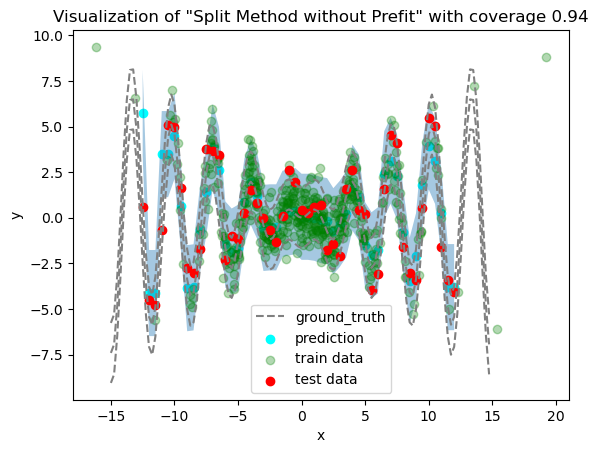

In [16]:
plot_data(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    y_pred=y_pred_split,
    y_pred_interval=y_interval_split,
    method="Split Method without Prefit"
)

## Jackknife Method


Main idea:
1. For each training instance $i = 1, \dots, l+k$ fit a model $\hat{h}_{-i}$ on all data points excluding i.
2. Given $i =1, \dots, l+k$ models $\hat{h}_{-i}$ the non-conformity scores are computed: $\alpha_i = y_i - \hat{h}_{-i}$.
3. Based on these scores $\alpha_1, \dots, \alpha_{l+k}$ the corresponding quantile $ q_{jack} =\lceil (1-\epsilon)*(l+k+1)\rceil \text{-quantile of the sequence }(\alpha_{1}, \, \alpha_{l+2}, \ldots , \alpha_{l+k})$ is calculated.
4. The prediction interval for a new instance $x_{N+1}$ is calculated through $\pm \ q_{jack}$:
$$
    [\hat{h}(x_{N+1}) - q_{jack} , \hat{h}(x_{N+1}) + q_{jack}]
$$
where $\hat{h}$ is the model trained on all $l+k$ data points.

In [17]:
model_missing_data = []
jackknife_non_conformity_scores = [0] * len(X_train)

# 1: Fit the \hat h_{-i} models on the training data
for i in range(len(X_train)):
    new_model = clone(base_model)
    
    X_train_missing_i, y_train_missing_i = np.delete(X_train, i, axis=0), np.delete(
        y_train, i, axis=0
    )
    new_model.fit(X_train_missing_i, y_train_missing_i)
    # 2: calculate non-conformity scores
    jackknife_non_conformity_scores[i] = np.abs(y_train[i] - new_model.predict(
        X_train[i].reshape(1, -1)
    ))
    model_missing_data.append(new_model)

jackknife_non_conformity_scores = np.array(jackknife_non_conformity_scores).ravel()

In [18]:
# 3: Compute quantile
jackknife_quantile = calculate_quantile(jackknife_non_conformity_scores, epsilon)

# 4: Get prediction intervals
jackknife_model = clone(base_model)  # done such that upper cells do not interfere here
jackknife_model.fit(X_train, y_train)

jackknife_prediction, jackknife_interval = get_prediction_interval_through_quantile(
    jackknife_model.predict(X_test), jackknife_quantile
)
print(jackknife_interval[:2])
output_mean_interval_width(jackknife_interval)

[[ 3.89881798  8.50609793]
 [-6.03573977 -1.42845983]]
Mean interval width:  4.607279945795659


Again as above in Split we gain firstly add the alpha-values to the prediction and then take the corresponding quantiles as bounds

In [19]:
# 4
jackknife_model = clone(base_model)  # done such that upper cells do not interfere here
jackknife_model.fit(X_train, y_train)

jackknife_prediction_2, jackknife_interval_2 = get_prediction_interval_through_scores(
    jackknife_model.predict(X_test), jackknife_non_conformity_scores
)
print(jackknife_interval_2[:2])
output_mean_interval_width(jackknife_interval_2)

[[ 3.89881798  8.50609793]
 [-6.03573977 -1.42845983]]
Mean interval width:  4.607279945795659


In [20]:
are_both_intervals_equal(jackknife_interval, jackknife_interval_2)

Are both inervals equal?
Yes, both are equal!


```{warning}
In most common cases the coverage of the jackknife method is equal to $1-\epsilon$.
But in scenarios where a regression model is less stable (samples size equal to number of features) the coverage might be less than $1-\epsilon$. For further details see {cite:t}`Barber2019PredictiveIW`.

```

Equally in MAPIE:

In [21]:
conformel_model = MapieRegressor(
    estimator=base_model, method="base", cv=-1, random_state=random_state
)
conformel_model.fit(X_train, y_train)
y_pred_jackknife, y_interval_jackknife = conformel_model.predict(X_test, alpha=epsilon)
y_interval_jackknife = y_interval_jackknife.reshape(-1, 2)
print(y_interval_jackknife[:2])
output_mean_interval_width(y_interval_jackknife)

[[ 3.89881798  8.50609793]
 [-6.03573977 -1.42845983]]
Mean interval width:  4.607279945795659


In [22]:
are_both_intervals_equal(y_interval_jackknife, jackknife_interval)

Are both inervals equal?
Yes, both are equal!


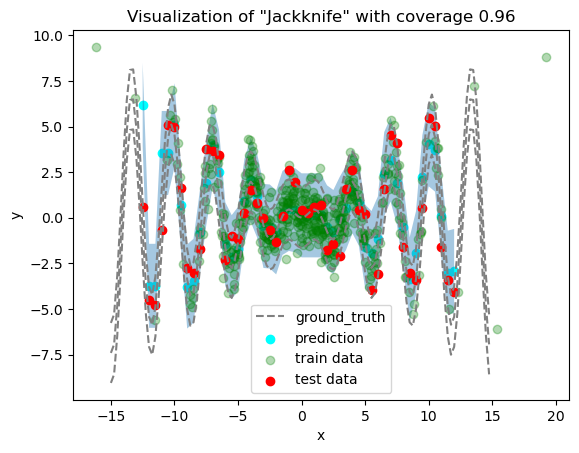

In [23]:
plot_data(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    y_pred=y_pred_jackknife,
    y_pred_interval=y_interval_jackknife,
    method="Jackknife"
)

## Jackknife+ Method

Main idea:
1. For each training instance $i = 1, \dots, l+k$ fit a model $\hat{h}_{-i}$ on all data points excluding i.
2. Given $i =1, \dots, l+k$ models $\hat{h}_{-i}$ the non-conformity scores are computed: $\alpha_i = y_i - \hat{h}_{-i}$.
3. Based on these scores $\alpha_1, \dots, \alpha_{l+k}$ the corresponding quantile $ q_{jack} =\lceil (1-\epsilon)*(l+k+1)\rceil \text{-quantile of the sequence }(\alpha_{1}, \, \alpha_{l+2}, \ldots , \alpha_{l+k})$ is calculated.
4. The prediction interval for a new instance $x_{N+1}$ is calculated through :
$$
    [q_{l+k,\epsilon}^{-}\left(\hat{h}_{-i}(x_{N+1}) - \alpha_i \right) , q_{l+k,\epsilon}^{+}\left(\hat{h}_{-i}(x_{N+1}) + \alpha_i \right) ]
$$
where $q_{n,\epsilon}^{+}(v_i)$ is the $\lceil (1-\epsilon)*(n+1)\rceil$ quantile of $v_1, \dots, v_n$ and $q_{l+k,\epsilon}^{-}(v_i)$ is the $\lfloor \epsilon(n+1)$ quantile of $v_1, \dots, v_n = -q_{n,\epsilon}^{+}(-v_i)$.

In [24]:
# 1: this is done above in jackknife
model_missing_data
# 2: see above in jackknife
jackknife_non_conformity_scores
# 3:
# get all predictions of the models \hat h_{-i}
missing_model_test_predictions = np.array([
    t.predict(X_test) for t in model_missing_data
]).T

# 4: build interval
jackknife_plus_prediction, jackknife_plus_interval = (
    get_prediction_interval_through_scores(
        missing_model_test_predictions, jackknife_non_conformity_scores
    )
)
print(jackknife_plus_interval[:2])
output_mean_interval_width(jackknife_plus_interval)

[[ 3.87031892  8.48400896]
 [-6.36664416 -1.59712437]]
Mean interval width:  4.655773126028885


In [25]:
mapie_jackknife_plus = MapieRegressor(
    estimator=base_model, method="plus", cv=-1, random_state=random_state
)
mapie_jackknife_plus.fit(X_train, y_train)

y_pred_jackknife_plus, y_interval_jackknife_plus = mapie_jackknife_plus.predict(X_test, alpha=epsilon)
y_interval_jackknife_plus = y_interval_jackknife_plus.reshape(-1, 2)

print(y_interval_jackknife_plus[:2])
output_mean_interval_width(y_interval_jackknife_plus)

[[ 3.87031892  8.48400896]
 [-6.36664416 -1.59712437]]
Mean interval width:  4.655773126028885


In [26]:
are_both_intervals_equal(y_interval_jackknife_plus, jackknife_plus_interval)

Are both inervals equal?
Yes, both are equal!


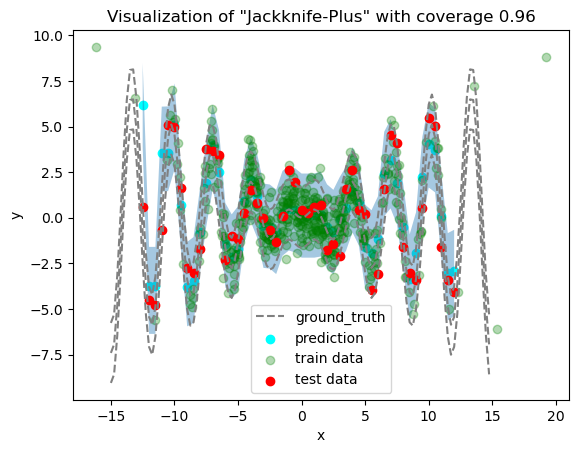

In [27]:
plot_data(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    y_pred=y_pred_jackknife_plus,
    y_pred_interval=y_interval_jackknife_plus,
    method="Jackknife-Plus"
)